In [9]:
import numpy as np
from numpy.typing import ArrayLike
dataset = "mushrooms.txt" 
from lovely_numpy import lo
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from typing import List

In [10]:
data = load_svmlight_file(dataset)
D, b = data[0].toarray(), data[1]
b = 2 * b - 3

In [11]:
from sklearn.model_selection import train_test_split

D_train, D_val, b_train, b_val = train_test_split(D, b, test_size=0.25)

In [12]:
np.random.seed(42)

def quantize_vector(v: ArrayLike, K, indeces_given=False, erase_ids=None) -> ArrayLike:
    # randK quantization of the vector
    # K - number of nonzero vector elements after the quantization
    if indeces_given:
        v[erase_ids] = 0
        return v

    to_erase = len(v) - K
    rand_indeces = np.random.choice(len(v), size=to_erase, replace=False)
    v[rand_indeces] = 0
    return v


def calculate_loss(DX: ArrayLike, b: ArrayLike) -> np.float32:
    # ||DX - b||_2^2
    return np.linalg.norm(DX - b) ** 2


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def accuracy_score(D, X, b):
    vals = D @ X
    # preds = sigmoid(vals)
    preds = [-1 if val < 0 else 1 for val in vals]
    return np.sum(preds == b) / len(b)

In [13]:
np.random.seed(42)


class ClientServer:
    def __init__(self, d_i: ArrayLike, gamma=5e-4) -> None:
        self.d = d_i
        self.x = np.random.random()
        self.f = None
        self.gamma = gamma
        self.grad = None

    # calculate target function on the client feature
    # f_i = d_i * x_i
    def calculate_local_function(self) -> ArrayLike:
        f_i = self.d * self.x
        self.f = f_i

    def calculate_quantized_local_function(self, K) -> ArrayLike:
        f_i = self.d * self.x
        self.f = quantize_vector(f_i, K)

    def calculate_quantized_local_function_robust(self, ids) -> ArrayLike:
        f_i = self.d * self.x
        self.f = quantize_vector(f_i, None, indeces_given=True, erase_ids=ids)

    def loss_gradient(self, error_vector: ArrayLike) -> np.float32:
        # error vector = DX - b
        # dL/(dx_i) = 2d_i^T(DX - b)
        dL = 2 * self.d.T @ error_vector
        self.grad = dL

    def gradient_step(self):
        # x^{k+1} = x - 2gamma*d_i^T(DX - b)
        # error_vector = DX - b
        self.x = self.x - self.gamma * self.grad
        self.grad = None

In [14]:
np.random.seed(42)


# Calculating DX = sum(d_i * x_i) for all clients
def client_values_aggregation(clients: List) -> ArrayLike:
    # dx_values - vector of dx values from all clients (matrix)
    # return - aggregation of all dx values (sum)
    dx_values = np.array(list(map(lambda x: x.f, clients)))
    return np.sum(dx_values, axis=0)  # DX

# collect x_i from all clients
def construct_full_vector(clients: List[ClientServer]):
    X = []
    for client in clients:
        X.append(client.x)
    return np.array(X)

In [15]:
Hessian = 2 * D.T @ D
L = np.max(np.linalg.eigvalsh(Hessian))
L

168083.23548991693

In [16]:
np.random.seed(42)


def train(
    feature_clients,
    b,
    iter_num=1000,
    quantization=False,
    K=1000,
    track_acc_history=False,
):
    loss_history = []
    grad_norm_history = []
    acc_hist = []

    progress = tqdm(range(iter_num))
    for i in progress:
        DX = client_values_aggregation(feature_clients)
        loss = calculate_loss(DX, b)
        error_vector = DX - b
        if quantization:
            error_vector = quantize_vector(error_vector, K)
        grad_norm = 0

        for client in feature_clients:
            if quantization:
                client.calculate_quantized_local_function(K)
            else:
                client.calculate_local_function()
            client.loss_gradient(error_vector)
            grad_norm += client.grad**2
            client.gradient_step()

        if track_acc_history:
            if i % 20 == 0:
                X = construct_full_vector(feature_clients)
                acc = accuracy_score(D_val, X, b_val)
            acc_hist.append(acc)
        loss_history.append(loss)
        grad_norm /= len(feature_clients)
        grad_norm_history.append(grad_norm)
        progress.set_description(f"Loss: {loss:.3e}, Mean gradient: {grad_norm:.3e}")
    return loss_history, grad_norm_history, acc_hist if track_acc_history else None

In [17]:
np.random.seed(42)

feature_clients = []

for feature in D_train.T:
    client = ClientServer(feature, gamma=1/L)
    client.calculate_local_function()
    feature_clients.append(client)

loss_history, grad_norm_history, acc_hist = train(
    feature_clients,
    b_train,
    iter_num=1500,
    quantization=False,
    track_acc_history=False,
)

Loss: 4.107e+03, Mean gradient: 6.670e+05:   1%|          | 15/1500 [00:00<00:10, 144.48it/s]

Loss: 1.370e+02, Mean gradient: 1.893e+02: 100%|██████████| 1500/1500 [00:08<00:00, 178.59it/s]


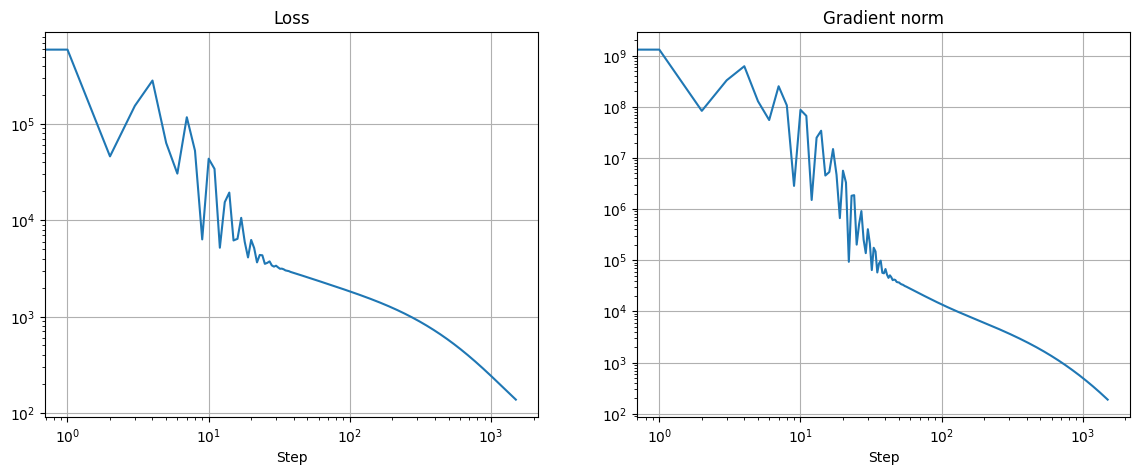

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].loglog(loss_history)
axes[0].grid()
axes[0].set_title("Loss")
axes[0].set_xlabel('Step')


axes[1].loglog(grad_norm_history)
axes[1].grid()
axes[1].set_title("Gradient norm")
axes[1].set_xlabel('Step')

plt.show()

In [19]:
X = construct_full_vector(feature_clients)
acc_train = accuracy_score(D_train, X, b_train)
acc_val = accuracy_score(D_val, X, b_val)
print(f"Accuracy on train set: {acc_train:.3f}")
print(f"Accuracy on val set: {acc_val}")

Accuracy on train set: 0.997
Accuracy on val set: 0.9950763170851797


Loss: 6.764e+03, Mean gradient: 5.219e+02:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss: 6.401e+03, Mean gradient: 3.668e+02: 100%|██████████| 1500/1500 [00:25<00:00, 58.72it/s]


Accuracy on train set With K = 100: 0.521
Accuracy on val set With K = 100: 0.5086164451009355


Loss: 1.087e+04, Mean gradient: 1.500e+03: 100%|██████████| 1500/1500 [00:25<00:00, 58.94it/s]


Accuracy on train set With K = 1000: 0.956
Accuracy on val set With K = 1000: 0.9537173806006893


Loss: 9.668e+03, Mean gradient: 1.650e+03: 100%|██████████| 1500/1500 [00:25<00:00, 59.68it/s]


Accuracy on train set With K = 2000: 0.975
Accuracy on val set With K = 2000: 0.9778434268833087


Loss: 1.212e+02, Mean gradient: 1.284e+02: 100%|██████████| 1500/1500 [00:08<00:00, 173.81it/s]


Accuracy on train set without Quantization: 1.000
Accuracy on val set  without Quantization: 0.9980305268340719


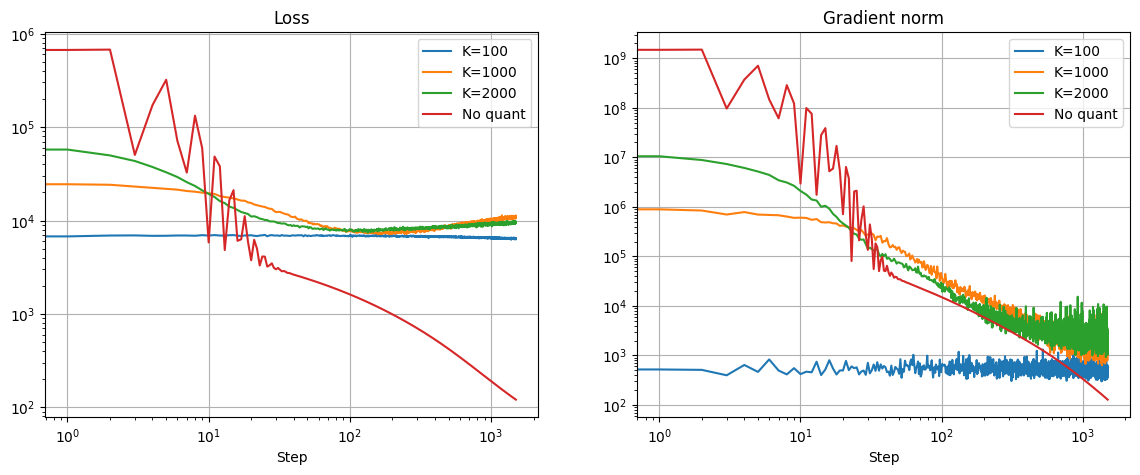

In [20]:
np.random.seed(42)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].grid()
axes[0].set_title("Loss")
axes[0].set_xlabel('Step')
axes[1].grid()
axes[1].set_title("Gradient norm")
axes[1].set_xlabel('Step')

Ks = [100, 1000, 2000, 0]
for k in Ks:
    erase_ids = np.random.choice(D_train.shape[0], size=D_train.shape[0] - k, replace=False)
    
    feature_clients = []
    for feature in D_train.T:
        client = ClientServer(feature, gamma=1/L)
        client.calculate_quantized_local_function_robust(erase_ids)
        feature_clients.append(client)

    q = True
    if k == 0:
        q = False
    loss_history, grad_norm_history, acc_hist = train(
        feature_clients,
        b_train,
        iter_num=1500,
        quantization=q,
        K=k,
        track_acc_history=False,
    )
    label = f'K={k}'
    if k == 0:
        label = 'No quant'
    axes[0].loglog(loss_history, label=label)
    axes[1].loglog(grad_norm_history, label=label)
    X = construct_full_vector(feature_clients)
    acc_train = accuracy_score(D_train, X, b_train)
    acc_val = accuracy_score(D_val, X, b_val)
    if k != 0:
        print(f"Accuracy on train set With K = {k}: {acc_train:.3f}")
        print(f"Accuracy on val set With K = {k}: {acc_val}")
    else:
        print(f"Accuracy on train set without Quantization: {acc_train:.3f}")
        print(f"Accuracy on val set  without Quantization: {acc_val}")       
    print('='*75)

axes[0].legend()
axes[1].legend()
plt.show()